# Bitcoin & Twitter

In [4]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import col, desc
from pyspark.sql import functions as F


sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

/usr/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
plt.style.use('ggplot')

import re

In [6]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', IntegerType(), True),
    StructField('user_favourites', IntegerType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])


tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True,
    sep=',',
    multiLine=True,
    schema=tweets_schema

)

btc_schema = StructType([
StructField('Unix Timestamp', StringType(), True),
StructField('Date', StringType(), True),

StructField('Symbol', StringType(), True),
StructField('Open', FloatType(), True),
StructField('High', FloatType(), True),
StructField('Low', FloatType(), True),
StructField('Close', FloatType(), True),
StructField('Volume', FloatType(), True),
])

btc_df = spark.read.csv(
    "./data/bitcoinvalue.csv",
    sep=',',
    # header=True,
    multiLine=True,
    schema=btc_schema)

tweets_df.show(50)

+--------------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|           user_name|       user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|            hashtags|              source|is_retweet|
+--------------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|       DeSota Wilson|         Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|        7605|           4838|        false|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|     Twitter Web App|     false|
|            CryptoND|                null|😎 BITCOIN

## Bitcoin

In [7]:
btc_df.describe(["unix Timestamp"]).show()

+-------+--------------------+
|summary|      unix Timestamp|
+-------+--------------------+
|  count|              658066|
|   mean|1.598615073055093...|
| stddev|1.188578608457691E10|
|    min|         1.57784E+12|
|    max|      Unix Timestamp|
+-------+--------------------+



##### Date

In [8]:
btc_df.describe(["Date"]).show()

+-------+-------------+
|summary|         Date|
+-------+-------------+
|  count|       658066|
|   mean|         null|
| stddev|         null|
|    min|1/1/2020 0:00|
|    max|         Date|
+-------+-------------+



##### Symbol
We're going to drop this one. As BTC will be the only currency in this project for now.

In [9]:


tweets_vol = tweets_df.groupBy('date').count()
fig, ax = plt.subplots()

ax.plot(tweets_vol.index,tweets_vol,label='Total Tweets')
ax.set_yscale('log')
ax.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()

# plt.figure(figsize=(25, 10))
# plt.plot(x[0:50], y[0:50], label='# tweets / user')
#
# plt.xlabel('username')
# plt.ylabel('# tweets')
# plt.title('# tweets / user')
# plt.legend()

ax.legend(lines, labels, loc=0)
plt.title("Total Tweets / Date")

plt.show()

btc_df.drop("symbol")

DataFrame[Unix Timestamp: string, Date: string, Open: float, High: float, Low: float, Close: float, Volume: float]

##### Open

In [10]:
btc_df.describe(["Open"]).show()

+-------+------------------+
|summary|              Open|
+-------+------------------+
|  count|            658065|
|   mean| 19816.05686497067|
| stddev|16737.625581943135|
|    min|           3935.29|
|    max|           64890.0|
+-------+------------------+



##### High

In [11]:
btc_df.describe(["High"]).show()

+-------+------------------+
|summary|              High|
+-------+------------------+
|  count|            658065|
|   mean|19828.754550129186|
| stddev| 16750.78659856924|
|    min|           3939.26|
|    max|           64900.0|
+-------+------------------+



##### Low

In [12]:
btc_df.describe(["Low"]).show()

+-------+-----------------+
|summary|              Low|
+-------+-----------------+
|  count|           658065|
|   mean|19803.07899750394|
| stddev|16723.50994893312|
|    min|          3901.25|
|    max|         64775.62|
+-------+-----------------+



##### Close

In [13]:
btc_df.describe(["Close"]).show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|            658065|
|   mean|19816.127877271825|
| stddev| 16737.67769446023|
|    min|           3935.29|
|    max|           64890.0|
+-------+------------------+



##### Volume

In [14]:
btc_df.describe(["Volume"]).show()

+-------+------------------+
|summary|            Volume|
+-------+------------------+
|  count|            658065|
|   mean|1.5524923808661875|
| stddev| 6.235547587336759|
|    min|               0.0|
|    max|           1043.58|
+-------+------------------+



## TWITTER

In [15]:
tweets_df.count()

1272097

##### user_name
Should be dropped

In [16]:
tweets_df.drop("user_name")

DataFrame[user_location: string, user_description: string, user_created: string, user_followers: float, user_friends: int, user_favourites: int, user_verified: boolean, date: string, text: string, hashtags: string, source: string, is_retweet: boolean]

##### user_location

In [17]:
tweets_df.select(F.countDistinct("user_location")).show()
tweets_df.select([F.count(F.when(col("user_location").isNull(), "user_location"))]).show()

+-----------------------------+
|count(DISTINCT user_location)|
+-----------------------------+
|                        49995|
+-----------------------------+

+---------------------------------------------------------------+
|count(CASE WHEN (user_location IS NULL) THEN user_location END)|
+---------------------------------------------------------------+
|                                                         604387|
+---------------------------------------------------------------+



##### user_description

Should be dropped

In [18]:
tweets_df.drop("user_description")

DataFrame[user_name: string, user_location: string, user_created: string, user_followers: float, user_friends: int, user_favourites: int, user_verified: boolean, date: string, text: string, hashtags: string, source: string, is_retweet: boolean]

##### user_created

In [19]:
tweets_df.describe(["user_created"]).show()

tweets_df.select([F.count(F.when(col("user_created").isNull(), "user_created"))]).show()

+-------+--------------------+
|summary|        user_created|
+-------+--------------------+
|  count|             1248202|
|   mean|   2139.339964370546|
| stddev|   7408.745470877948|
|    min|                    |
|    max|🤓EWI CEWA-M #Ell...|
+-------+--------------------+

+-------------------------------------------------------------+
|count(CASE WHEN (user_created IS NULL) THEN user_created END)|
+-------------------------------------------------------------+
|                                                        23895|
+-------------------------------------------------------------+



##### user_followers

In [20]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                            41104|
+-----------------------------------------------------------------+



##### user_followers

In [21]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

+-----------------------------------------------------------------+
|count(CASE WHEN (user_followers IS NULL) THEN user_followers END)|
+-----------------------------------------------------------------+
|                                                            41104|
+-----------------------------------------------------------------+



##### user_friends

In [22]:
tweets_df.select([F.count(F.when(col("user_friends").isNull(), "user_friends"))]).show()

+-------------------------------------------------------------+
|count(CASE WHEN (user_friends IS NULL) THEN user_friends END)|
+-------------------------------------------------------------+
|                                                      1012559|
+-------------------------------------------------------------+



##### user_favourites

In [23]:
tweets_df.select([F.count(F.when(col("user_favourites").isNull(), "user_favourites"))]).show()

+-------------------------------------------------------------------+
|count(CASE WHEN (user_favourites IS NULL) THEN user_favourites END)|
+-------------------------------------------------------------------+
|                                                            1012355|
+-------------------------------------------------------------------+



##### user_verified

In [24]:
tweets_df.select(F.count(F.when(col("user_verified").isNull(), "user_verified")),
                 F.count(F.when(col("user_verified") == "false", "user_verified")),
                 F.count(F.when(col("user_verified") == "true", "user_verified"))).show()

+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|count(CASE WHEN (user_verified IS NULL) THEN user_verified END)|count(CASE WHEN (user_verified = false) THEN user_verified END)|count(CASE WHEN (user_verified = true) THEN user_verified END)|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+
|                                                          44446|                                                        1217748|                                                          9903|
+---------------------------------------------------------------+---------------------------------------------------------------+--------------------------------------------------------------+



##### date

In [25]:
tweets_df.select(F.countDistinct("date")).show()
tweets_df.select([F.count(F.when(col("date").isNull(), "date"))]).show()

+--------------------+
|count(DISTINCT date)|
+--------------------+
|              999096|
+--------------------+

+---------------------------------------------+
|count(CASE WHEN (date IS NULL) THEN date END)|
+---------------------------------------------+
|                                        39418|
+---------------------------------------------+



##### text

In [26]:
tweets_df.select(F.count(F.when(col("text").isNull(), "text"))).show()

+---------------------------------------------+
|count(CASE WHEN (text IS NULL) THEN text END)|
+---------------------------------------------+
|                                        39427|
+---------------------------------------------+



##### hashtags

In [27]:
tweets_df.select(F.countDistinct("hashtags")).show()
tweets_df.select([F.count(F.when(col("hashtags").isNull(), "hashtags"))]).show()

+------------------------+
|count(DISTINCT hashtags)|
+------------------------+
|                  292657|
+------------------------+

+-----------------------------------------------------+
|count(CASE WHEN (hashtags IS NULL) THEN hashtags END)|
+-----------------------------------------------------+
|                                                67129|
+-----------------------------------------------------+



##### source

In [28]:
tweets_df.select(F.countDistinct("source")).show()
tweets_df.select([F.count(F.when(col("source").isNull(), "source"))]).show()

+----------------------+
|count(DISTINCT source)|
+----------------------+
|                  4738|
+----------------------+

+-------------------------------------------------+
|count(CASE WHEN (source IS NULL) THEN source END)|
+-------------------------------------------------+
|                                            59410|
+-------------------------------------------------+



##### is_retweet

In [29]:
tweets_df.select(F.count(F.when(col("is_retweet").isNull(), "is_retweet")).alias("null values"),
                 F.count(F.when(col("is_retweet") == "false", "is_retweet")),
                 F.count(F.when(col("is_retweet") == "true", "is_retweet"))).show()

+-----------+---------------------------------------------------------+--------------------------------------------------------+
|null values|count(CASE WHEN (is_retweet = false) THEN is_retweet END)|count(CASE WHEN (is_retweet = true) THEN is_retweet END)|
+-----------+---------------------------------------------------------+--------------------------------------------------------+
|      62182|                                                  1209915|                                                       0|
+-----------+---------------------------------------------------------+--------------------------------------------------------+



## Preparing Data    Date|
+-------+-------------+

In [30]:
from pyspark.sql.functions import udf

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)

conv_to_int_udf = udf(lambda x : conv_to_int(x), IntegerType())

tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
    .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
    .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))    Date|
+-------+-------------+

### Text cleaning

In [31]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

clean_text_udf = udf(lambda x : clean_text(x), StringType())

tweets_df.withColumn("text", clean_text_udf(col("text")))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: string, text: string, hashtags: string, source: string, is_retweet: boolean]

### Generating impact score

In [32]:
from pyspark.sql.functions import struct

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

generate_impact_score_udf = udf(lambda x : generate_impact_score(x), FloatType())

tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

DataFrame[user_name: string, user_location: string, user_description: string, user_created: string, user_followers: int, user_friends: int, user_favourites: int, user_verified: boolean, date: string, text: string, hashtags: string, source: string, is_retweet: boolean, impact_score: float]

## Data visualisation

### Twitter

+--------------------+-----+
|                date|count|
+--------------------+-----+
|                null|39418|
|               False| 1033|
|['crypto', 'bitco...|  751|
|         ['Bitcoin']|  503|
|         ['bitcoin']|  228|
| 2021-04-06 01:20:48|   83|
| 2021-06-22 20:19:20|   73|
|             ['BTC']|   72|
|['Trades', 'dogec...|   70|
| 2021-04-07 09:14:56|   64|
|  ['Bitcoin', 'BTC']|   57|
|['Trades', 'ether...|   44|
|['horseracing', '...|   41|
| 2021-04-10 04:59:13|   38|
| 2021-04-06 14:23:06|   37|
|['dogecoin', 'Bit...|   36|
| 2021-04-06 00:01:16|   34|
| 2021-04-07 11:28:32|   33|
|              2287.0|   32|
|               264.0|   30|
+--------------------+-----+
only showing top 20 rows



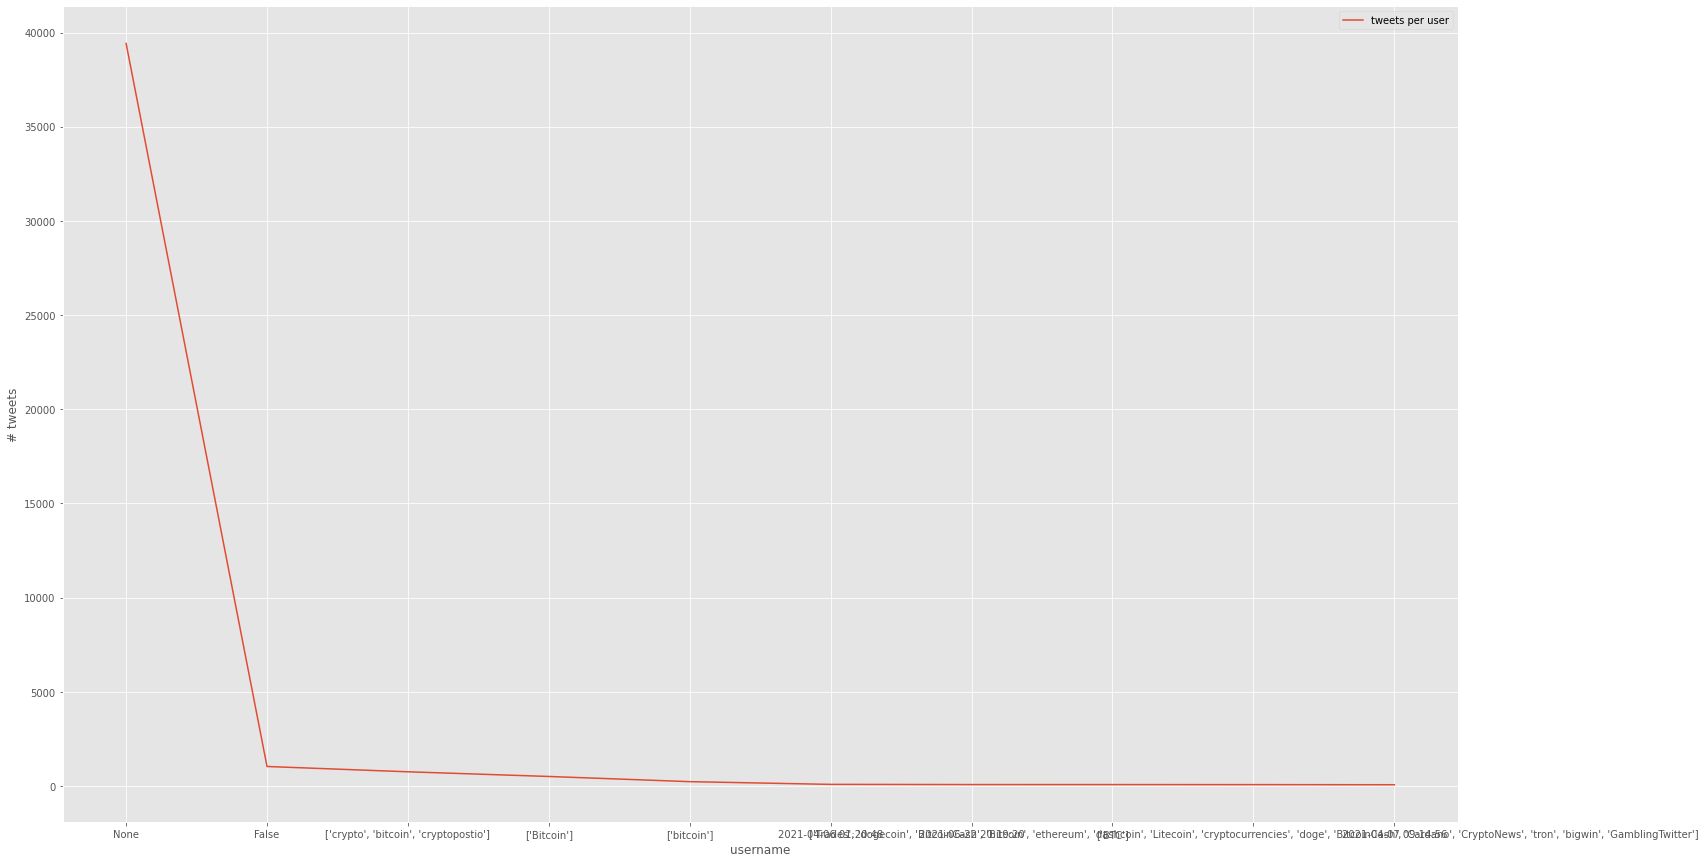

In [36]:
%matplotlib inline

tweets_volume = tweets_df.groupby("date").count().sort(desc("count"))
tweets_volume.show()


n = 10
x_rows = tweets_volume.limit(n).select("date").collect()
x = list(map(lambda r : str(r['date']), x_rows))

y_rows = tweets_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Tweets / user

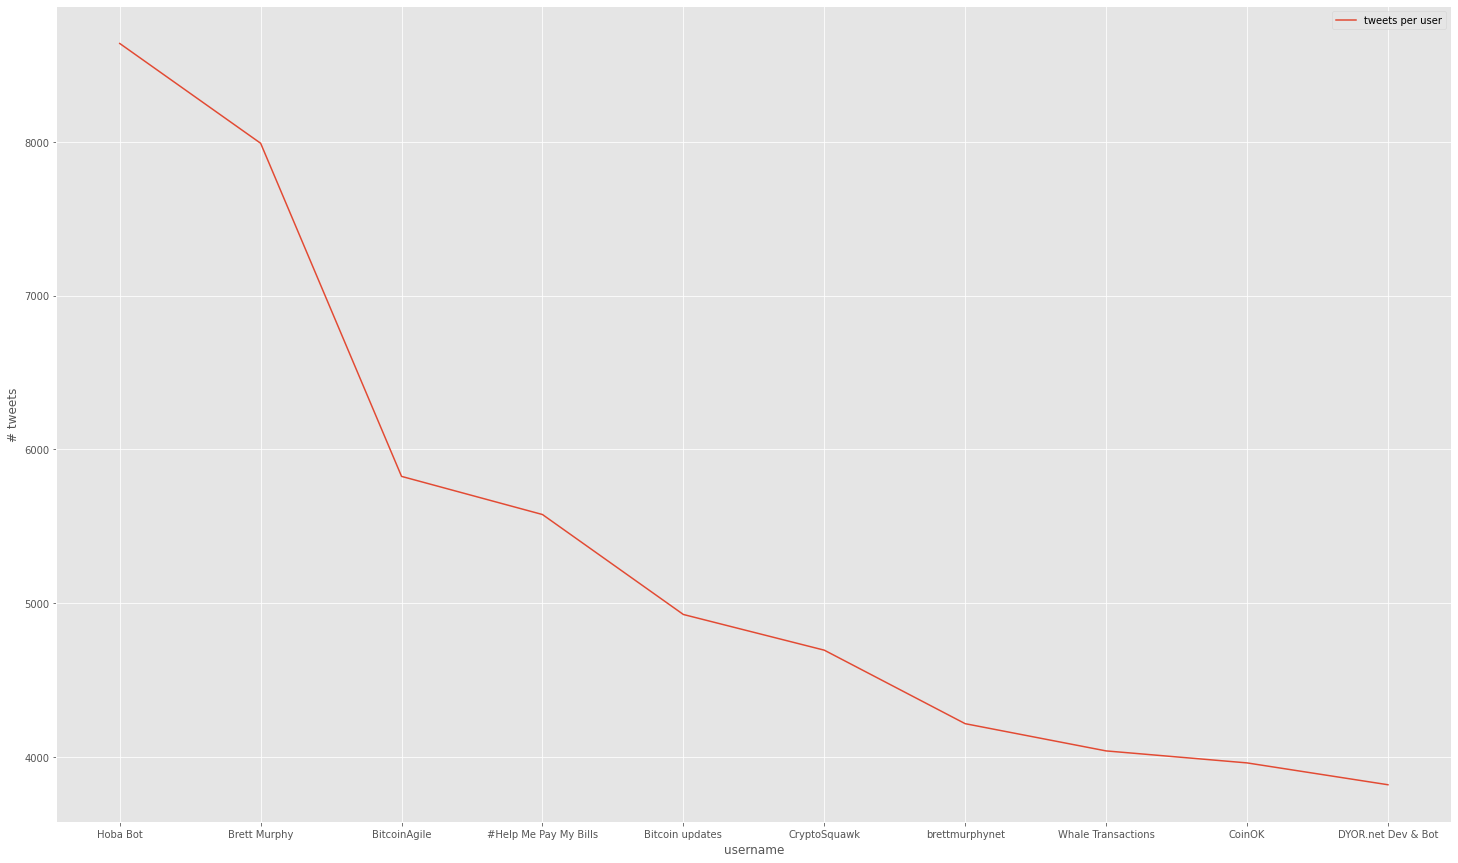

In [37]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().sort(desc("count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
x = list(map(lambda r : str(r['user_name']), x_rows))

y_rows = user_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Bitcoin Value

In [32]:
# fig, ax = plt.subplots()
# ax.plot(btc_value_df['Date'],btc_value_df['Open'],label='Bitcoin Value')
# ax.tick_params(axis='y')
#
# lines, labels = ax.get_legend_handles_labels()
#
# ax.legend(lines, labels)
# plt.title("Bitcoin Value")
#
# plt.show()

In [33]:
df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()

+--------------------+------+
|       user_location| count|
+--------------------+------+
|                null|604387|
|       United States| 14502|
|        Bay Area, CA| 12461|
|     London, England| 10635|
|              Global| 10532|
|           Australia|  8606|
|           Worldwide|  7503|
|               India|  7007|
|          Blockchain|  6944|
|      United Kingdom|  6348|
|                Moon|  6084|
|              Canada|  6068|
|Matter Doesn't Ma...|  5824|
|               Earth|  5252|
|       New York, USA|  5229|
|                 USA|  5193|
|     Los Angeles, CA|  4492|
|            Internet|  4457|
|                Mars|  4440|
|England, United K...|  4111|
+--------------------+------+
only showing top 20 rows

